
# Simulation-Based Experiment: How Does Network Topology Affect Spreading?

In this notebook, we design and run a **simulation-based experiment** to understand how **network structure** influences the spread of a contagion (e.g., an epidemic or idea).

This follows the steps discussed in the lecture:

1. Define the research question — *How does network topology affect spreading?*
2. Choose models of network structure.
3. Define the spreading process (SIR model).
4. Decide on parameters and initial conditions.
5. Run simulations for different network types.
6. Measure quantities of interest (e.g. epidemic size, duration).
7. Compare results and draw conclusions.


## 1. Import required packages

In [ ]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd
from collections import defaultdict

# For reproducibility
#random numbers in code are pseudo-random numbers
#they work by using a seed value as a start point to generate a sequence of numbers
#that look random, but are actually deterministic
#this means that if you use the same seed value, you will get the same sequence of numbers
random.seed(42)
np.random.seed(42)

#We have two seeds here because there are two different random number generators in the code
#one is the random module in python
#the other is the numpy random module
#we need to set both seeds to ensure that we get the same sequence of random numbers


## 2. Define network models

We will generate three classic network topologies:

- **Erdős–Rényi (ER)**: random connections (homogeneous).
- **Watts–Strogatz (WS)**: small-world networks with clustering.
- **Barabási–Albert (BA)**: scale-free networks with hubs.

These represent increasing levels of structural heterogeneity.


Erdos-Renyi     | avg degree ≈ 5.71 | density = 0.029
Watts-Strogatz  | avg degree ≈ 6.00 | density = 0.030
Barabasi-Albert | avg degree ≈ 5.91 | density = 0.030


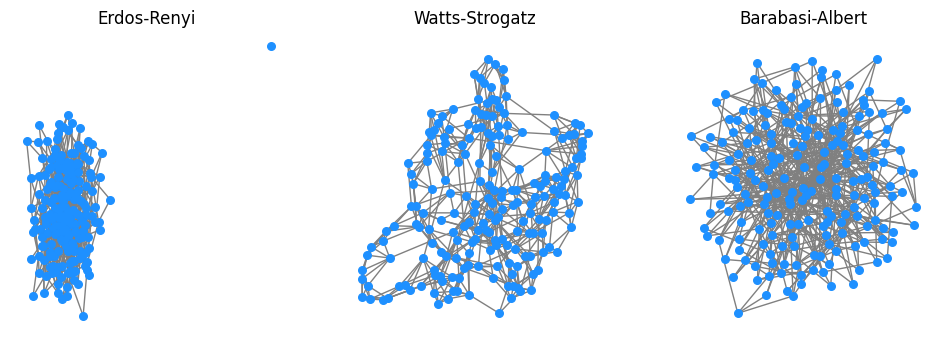

In [ ]:

# This is a function definition, it doesn't run code but defines a function
# that can be called later in the code. This function generates three types of networks:
# Erdos-Renyi, Watts-Strogatz, and Barabasi-Albert. The parameters define the number of nodes (n),
# the average degree (k for WS), the probability of edge creation (p for ER and WS),
# and the number of edges to attach to each new node (m for BA).
def generate_networks(n=200, k_target=6, rewiring_p=0.1):
    """
    Generate ER, WS, and BA networks with roughly the same average degree.
    
    Parameters
    ----------
    n : int
        Number of nodes.
    k_target : float
        Desired average degree across all networks.
    rewiring_p : float
        Rewiring probability for the Watts-Strogatz model.
    """
    # Derived parameters for each model to get the right average degree
    p_er = k_target / (n - 1)               # for ER: p = <k> / (n-1)
    k_ws = int(round(k_target))             # for WS: k = <k>
    m_ba = max(1, int(round(k_target / 2))) # for BA: <k> = 2m

    # Generate graphs
    G_er = nx.erdos_renyi_graph(n, p_er)
    G_ws = nx.watts_strogatz_graph(n, k_ws, rewiring_p)
    G_ba = nx.barabasi_albert_graph(n, m_ba)

    # Print average degree and density for comparison
    for name, G in {"Erdos-Renyi": G_er, "Watts-Strogatz": G_ws, "Barabasi-Albert": G_ba}.items():
        avg_k = sum(dict(G.degree()).values()) / n
        print(f"{name:15s} | avg degree ≈ {avg_k:.2f} | density = {nx.density(G):.3f}")

    return {"Erdos-Renyi": G_er, "Watts-Strogatz": G_ws, "Barabasi-Albert": G_ba}

# call the function to generate the networks
networks = generate_networks()

#This is a plot of the three networks, we use matplotlib to create a figure with three subplots
#each subplot shows one of the networks, 1,3 means 1 row, 3 columns. figsize=(12, 4) means the 
# figure is 12 inches wide and 4 inches high
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, (name, G) in zip(axs, networks.items()):
    #This is a plot of the network G on the axis ax
    #nx.draw_spring is a function from the networkx library that draws the network
    #using a spring layout, which means that nodes are spaced out in a way that
    #minimizes the number of edges crossing between them
    #node_size=30 means that each node is 30 points wide
    #edge_color="gray" means that the edges are gray
    #node_color="dodgerblue" means that the nodes are blue
    nx.draw_spring(G, ax=ax, node_size=30, edge_color="gray", node_color="dodgerblue")
    ax.set_title(name)
plt.show()



## 3. Define the SIR spreading process

The **SIR model** simulates how nodes transition through states:

- **S**usceptible  
- **I**nfected  
- **R**ecovered  

Parameters:
- `beta`: transmission probability per contact
- `mu`: recovery probability per infected node per step


In [30]:
# This is the function that simulates the SIR process on a graph G, we can use this 
# function to simulate the SIR process on any graph G
def simulate_sir(G, beta=0.05, mu=0.02, initial_infected=5, max_steps=800):
    """Simulate an SIR process on graph G. Returns S, I, R over time."""
    
    #This is a dictionary that stores the state of each node (S, I, or R)
    #This syntax is called a dictionary comprehension and it is a concise way to create dictionaries
    #The equivalent code could be:
    # state = {}
    # for node in G.nodes():
    #     state[node] = 'S'
    state = {node: 'S' for node in G.nodes()} # Initialize all nodes as susceptible

    # Randomly select initial infected nodes
    infected_nodes = random.sample(list(G.nodes()), initial_infected) 

    # Set the initial infected nodes to the 'I' state
    for node in infected_nodes:
        state[node] = 'I'

    #This is a list that stores the number of each type at each iteration
    S_hist, I_hist, R_hist = [], [], []

    for _ in range(max_steps): #iterate max_steps times
        new_state = state.copy() # Create a copy of the current state
        for node in G.nodes():#iterate over all nodes in the graph G
            if state[node] == 'I':
                for neigh in G.neighbors(node):
                    if state[neigh] == 'S' and random.random() < beta: #if the neighbor is susceptible and the random number is less than beta
                        new_state[neigh] = 'I' #infect the neighbor
                if random.random() < mu: #if another random number is less than mu
                    new_state[node] = 'R' #we recover
        state = new_state
        S_hist.append(sum(v == 'S' for v in state.values())) #number of susceptible nodes add to results
        I_hist.append(sum(v == 'I' for v in state.values())) #number of infected nodes add to results
        R_hist.append(sum(v == 'R' for v in state.values())) #number of recovered nodes add to results
        if I_hist[-1] == 0: #there are no more infected nodes
            break

    return np.array(S_hist), np.array(I_hist), np.array(R_hist)



## 4. Run experiments across network topologies

We will use the same SIR parameters for each network and average results.


In [31]:
# a function to run experiments
def run_experiments(networks, beta=0.05, mu=0.02, reps=10):
    results = defaultdict(list) # a dictionary to store the results, defaultdict is a dictionary that returns a default value if the key is not found
    for name, G in networks.items(): # loop over the networks
        for _ in range(reps): # loop over the repetitions
            S, I, R = simulate_sir(G, beta, mu) # run the simulation
            #our results stored in a table eventually
            results["network"].append(name)
            results["final_size"].append(R[-1] / G.number_of_nodes())
            results["duration"].append(len(I))
    return pd.DataFrame(results)

df_results = run_experiments(networks)
df_results.groupby("network").mean() # group by network and calculate the mean


,final_size,duration
network,,
Barabasi-Albert,0.9885,317.3
Erdos-Renyi,0.9850,289.5
Watts-Strogatz,1.0000,325.7


### Visualize Results

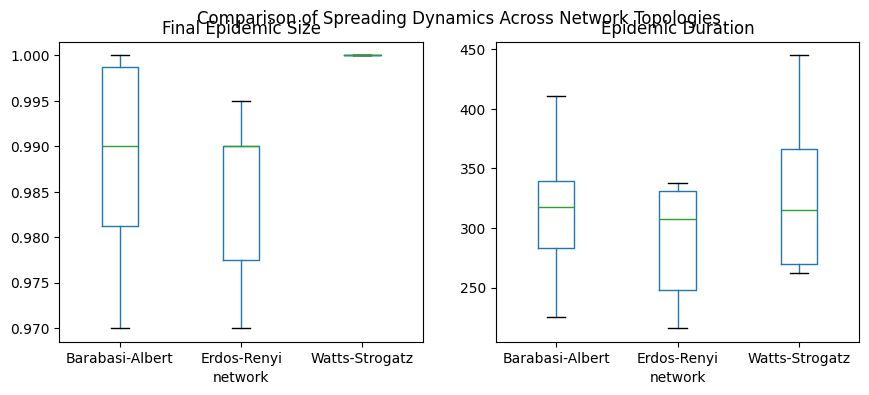

In [32]:

fig, axs = plt.subplots(1, 2, figsize=(10,4))
df_results.boxplot(column="final_size", by="network", ax=axs[0], grid=False)
df_results.boxplot(column="duration", by="network", ax=axs[1], grid=False)
axs[0].set_title("Final Epidemic Size")
axs[1].set_title("Epidemic Duration")
plt.suptitle("Comparison of Spreading Dynamics Across Network Topologies")
plt.show()



## 5. Parameter Sensitivity: Sweeping β

To explore the epidemic threshold, we vary β while keeping μ constant.


In [26]:

def sweep_beta(networks, beta_values, mu=0.02, reps=5):
    dfs = []
    for beta in beta_values:
        df = run_experiments(networks, beta, mu, reps)
        df["beta"] = beta
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

beta_values = np.linspace(0.01, 0.1, 10)
df_sweep = sweep_beta(networks, beta_values)


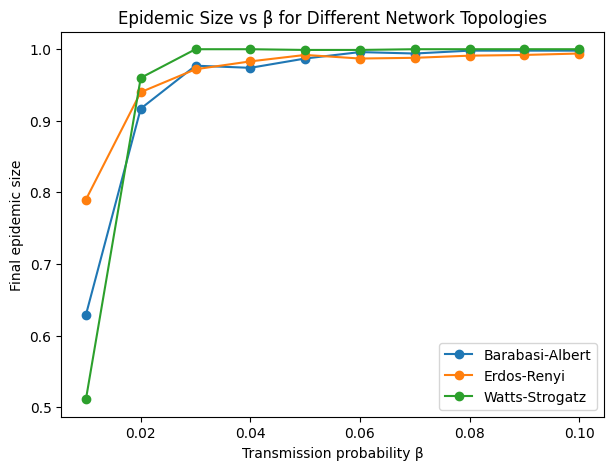

In [27]:

plt.figure(figsize=(7,5))
for name, group in df_sweep.groupby("network"):
    means = group.groupby("beta")["final_size"].mean()
    plt.plot(means.index, means.values, marker="o", label=name)
plt.xlabel("Transmission probability β")
plt.ylabel("Final epidemic size")
plt.title("Epidemic Size vs β for Different Network Topologies")
plt.legend()
plt.show()



## 6. Discussion

- Epidemics on **Barabási–Albert** networks tend to reach larger fractions at lower β (vanishing threshold).  
- **Watts–Strogatz** networks spread faster due to small-world shortcuts.  
- **Erdős–Rényi** networks require higher β for global outbreaks.

**Takeaway:** Structure drives dynamics. Simulations let us test hypotheses that are analytically difficult.
